In [11]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import pathlib
from glob import glob
from data_loader import get_pdf_filepaths

In [12]:
from IPython import get_ipython
ip = get_ipython()
ip.InteractiveTB.set_mode(mode="Verbose")

In [13]:
def get_agg_dfs_filepaths(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / '**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

# 0. Create dataset from the csvs of all books

In [14]:
DATA_DIR_PATH = "../data/"
PDF_SOURCE_DIR_PATH = DATA_DIR_PATH + "pdf/"
PROCESSED_DATA_DIR_PATH = DATA_DIR_PATH + "processed/"

In [15]:
file_paths = get_agg_dfs_filepaths(PROCESSED_DATA_DIR_PATH)
file_paths

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2015_Book_LinearAlgebra/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2007BoolosComputability and Logic Fifth Edition/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2014_Book_Microeconomics/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/jacobson_14/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/moltmann_97/ag

In [1]:
list_agg_dfs=[]
for path in file_paths:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df = pd.concat(list_agg_dfs)

NameError: name 'file_paths' is not defined

In [17]:
list_agg_dfs=[]
n=0
for path in file_paths:
    while n<11:
        aggregated_df = pd.read_csv(path,index_col=0)
        list_agg_dfs.append(aggregated_df)
        n+=1
    
df_s = pd.concat(list_agg_dfs)

In [18]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379489 entries, 0 to 34498
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    379489 non-null  object 
 1   length               379489 non-null  int64  
 2   is_named_entity      379489 non-null  int64  
 3   is_named_author      379489 non-null  int64  
 4   is_in_toc            379489 non-null  int64  
 5   freq                 379489 non-null  float64
 6   is_in_index          379489 non-null  int64  
 7   tfidf                379489 non-null  float64
 8   importance           379489 non-null  float64
 9   position_in_context  379489 non-null  float64
 10  POS                  379489 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 34.7+ MB


# 1. Feature engineering

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
df_s.reset_index(drop=True, inplace=True)

In [21]:
df.groupby('POS').count()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context
POS,,,,,,,,,,
ADJ,19629,19637,19637,19637,19637,19637,19637,19637,19637,19637
ADP,769,769,769,769,769,769,769,769,769,769
ADV,7305,7305,7305,7305,7305,7305,7305,7305,7305,7305
AUX,282,282,282,282,282,282,282,282,282,282
CCONJ,98,98,98,98,98,98,98,98,98,98
CHUNK,749051,749051,749051,749051,749051,749051,749051,749051,749051,749051
DET,167,167,167,167,167,167,167,167,167,167
INTJ,251,251,251,251,251,251,251,251,251,251
NOUN,43999,43999,43999,43999,43999,43999,43999,43999,43999,43999


In [22]:
df.dropna(inplace=True)

In [23]:
df_s.dropna(inplace=True)

In [24]:
textbook_words=['whereas', 
                'conversely', 
                'result',
                'suggest',
                'contrast', 
                'comparison', 
                'view', 
                'likewise',
                'despite',
                'while',
                'subsequent',
                'subsequently',
                'overall',
                'summary',
                'sumarize',
                'first',
                'second', 
                'third',
                'firstly',
                'secondly', 
                'thirdly',
                'finally',
                'although',
                'thus',
                'again',
                'further',
                'then',
                'besides',
                'too',
                'similarly',
                'correspondingly',
                'regarding',
                'involved',
                'approach',
                'account',
                'theory',
                'method',
                'required',
                'process',
                'research',
                'role',
                'significant',
                'source',
                'variable',
                'issue',
                'function',
                'formula',
                'formulate',
                'phrase',
                'factor',
                'evidence',
                'derived',
                'derive',
                'establish',
                'concept',
                'available',
                'context',
                'assume',
                'assumption',
                'additionally',
                'additional',
                'analysis',
                'general',
                'certain',
                'certainly',
                'furthermore',
                'moreover',
                'nonetheless',
                'nevertheless',
                'bibliography',
                'prove',
                'part',
                'today', 
                'nowadays', 
                'actually', 
                'section', 
                'indeed', 
                'every', 
                'any', 
                'some',
                'instance',
                'example', 
                'therefore', 
                'definition',
                'define',
                'explain',
                'explanation',
                'introduction', 
                'conclusion',
                'conclude',
                'chapter', 
                'appendix', 
                'otherwise', 
                'thing',
                'concisely',
                'concise',
                'brief',
                'briefly',
                'rather', 
                'instead', 
                'like', 
                'since', 
                'given', 
                'case', 
                'hence', 
                'iff', 
                'see', 
                'beyond', 
                'below', 
                'above', 
                'postscript',
                'preface',
                'index', 
                'ensure', 
                'generally', 
                'anything', 
                'something',
                'everything',
                'other']

In [25]:
dict_tbw={}
for w in df.candidate_keyword:
    if w in textbook_words:
        dict_tbw[w]=1
    else:
        dict_tbw[w]=0

In [26]:
def is_a_tbw(x):
    if w in textbook_words:
        return 1
    else: 
        return 0

In [14]:
df['is_a_textbook_word']=df.candidate_keyword.apply(lambda x: dict_tbw[x])

In [27]:
df_s['is_a_textbook_word']=df_s.candidate_keyword.apply(lambda x: dict_tbw[x])

In [15]:
df_scaled = pd.get_dummies(df, columns=['POS'],
prefix = ['POS'])

In [28]:
df_s_scaled = pd.get_dummies(df_s, columns=['POS'],
prefix = ['POS'])

In [29]:
df_s_scaled.head()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context,...,POS_CHUNK,POS_DET,POS_INTJ,POS_NOUN,POS_NUM,POS_PRON,POS_PROPN,POS_SCONJ,POS_VERB,POS_X
0,a-laying,8,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,0,0,0,1,0,0,0,0,0,0
1,a-laying police,15,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,1,0,0,0,0,0,0,0,0,0
2,aardvark,8,0,0,0,0.000013,0,0.000000,0.644323,1.000000,...,0,0,0,1,0,0,0,0,0,0
3,abandoned,9,0,0,0,0.000038,0,0.009811,0.449342,0.611827,...,0,0,0,0,0,0,0,0,1,0
4,abandoned commitment,20,0,0,0,0.000013,0,0.000000,0.392002,0.272727,...,1,0,0,0,0,0,0,0,0,0


In [17]:
df_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [30]:
df_s_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [18]:
df_scaled_columns = df_scaled.columns

In [31]:
df_s_scaled_columns = df_s_scaled.columns

In [20]:
scaler = MinMaxScaler() 

In [21]:
#not sure about this (do I need to concat or what?)
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns= df_scaled_columns)

In [22]:
df_scaled=df_scaled.rename(columns={"is_in_index": "target"})

In [23]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
length,856871.0,0.212469,0.077972,0.0,0.166667,0.216667,0.266667,1.0
is_named_entity,856871.0,0.009262,0.095791,0.0,0.000000,0.000000,0.000000,1.0
is_named_author,856871.0,0.002269,0.047577,0.0,0.000000,0.000000,0.000000,1.0
is_in_toc,856871.0,0.003747,0.061101,0.0,0.000000,0.000000,0.000000,1.0
freq,856871.0,0.000985,0.006721,0.0,0.000183,0.000280,0.000524,1.0
target,856871.0,0.010909,0.103877,0.0,0.000000,0.000000,0.000000,1.0
tfidf,856871.0,0.006953,0.031325,0.0,0.000000,0.000000,0.000000,1.0
importance,856871.0,0.607713,0.120286,0.0,0.531377,0.614473,0.692015,1.0
position_in_context,856871.0,0.446067,0.262398,0.0,0.230769,0.441026,0.650000,1.0
is_a_textbook_word,856871.0,0.002368,0.048604,0.0,0.000000,0.000000,0.000000,1.0


In [25]:
df_scaled.to_csv("../data/final_scaled.csv", encoding = 'utf-8')

# 2. Quick EDA

In [26]:
path = '../data/final_scaled.csv'
df_scaled = pd.read_csv(path,index_col=0)
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856870
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   is_a_textbook_word   856871 non-null  float64
 10  POS_ADJ              856871 non-null  float64
 11  POS_ADP              856871 non-null  float64
 12  POS_ADV              856871 non-null  float64
 13  POS_AUX              856871 non-null  float64
 14  POS_CCONJ            856871 non-null  float64
 15  POS_CHUNK        

### Pairplot all columns

In [ ]:
g = sns.pairplot(df_scaled, y_vars= df_scaled.columns.values, x_vars="target")
g.fig.set_size_inches(7,14)

In [ ]:
pairplot=sns.pairplot(df_scaled, hue='target')

In [ ]:
pairplot

In [ ]:
pairplot.figure.savefig("..images/images/pairplot.png")

### Boxplots

In [ ]:
for column in df_scaled.drop(['target'], axis=1):
    plt.figure()
    df_scaled.boxplot([column])

### Correlation heatmap

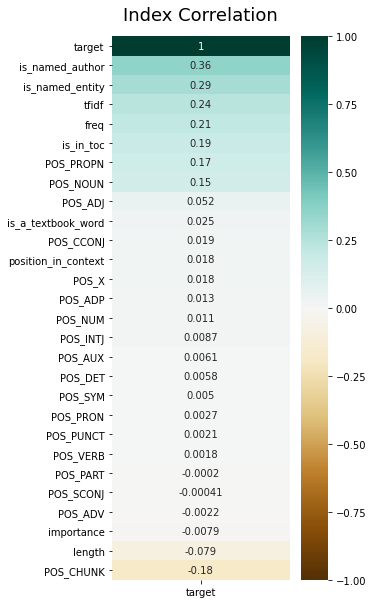

In [27]:
plt.figure(figsize=(4, 10))

heatmap = sns.heatmap(df_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [30]:
heatmap.figure.savefig("../images/heatmap.png", bbox_inches="tight")

# 3. Train and test the models

In [63]:
X = df_scaled.drop('target', axis= 1)
y = df_scaled.target

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [72]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856870
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   is_a_textbook_word   856871 non-null  float64
 10  POS_ADJ              856871 non-null  float64
 11  POS_ADP              856871 non-null  float64
 12  POS_ADV              856871 non-null  float64
 13  POS_AUX              856871 non-null  float64
 14  POS_CCONJ            856871 non-null  float64
 15  POS_CHUNK        

## Oversampling

In [73]:
#smote = SMOTE(random_state=42)

In [74]:
#X_sm,y_sm=smote.fit_resample(X_train, y_train)

In [75]:
#pickle.dump(X_sm, open('../models/X_sm.sav', 'wb'))
#pickle.dump(y_sm, open('../models/y_sm.sav', 'wb'))

In [76]:
X_sm = pickle.load(open('../models/X_sm.sav', 'rb'))
y_sm = pickle.load(open('../models/y_sm.sav', 'rb'))

In [87]:
print('\nBefore OVER-sampling\n', y_train.value_counts())


Before OVER-sampling
 0.0    593266
1.0      6543
Name: target, dtype: int64


In [88]:
print('\nAfter OVER-sampling\n', y_sm.value_counts())


After OVER-sampling
 0.0    593266
1.0    593266
Name: target, dtype: int64


## Undersampling

In [ ]:
sampler = ClusterCentroids()
X_cc, y_cc = sampler.fit_resample(X_train, y_train)

In [ ]:
pickle.dump(X_cc, open('../models/X_cc.sav', 'wb'))
pickle.dump(y_cc, open('../models/y_cc.sav', 'wb'))

In [ ]:
X_cc = pickle.load(open('../models/X_cc.sav', 'rb'))
y_cc = pickle.load(open('../models/y_cc.sav', 'rb'))

In [ ]:
print('\nBefore UNDER-sampling\n', y_train.value_counts())
print('\nAfter UNDER-resampling\n', y_cc.value_counts())

## 3.1. Logistic regression

In [ ]:
model_LR = LogisticRegression(random_state=42)

In [ ]:
params_LR = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

In [ ]:
grid_search_cv_LR = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_LR.fit(X_train, y_train)

In [ ]:
grid_search_cv_LR.best_params_

In [ ]:
log_reg = LogisticRegression(random_state=42, penalty='l2', C=5, max_iter=200)

In [ ]:
log_reg.fit(X_train, y_train)

y_pred_LR = log_reg.predict(X_test)

#### Metrics

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_LR)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_LR)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_LR)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_LR)))

In [ ]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_LR)))

In [ ]:
#another way of doing logistic regression with cv (I think the same thing does not exist for random forest):
log_reg_cv = LogisticRegressionCV(random_state=42)

log_reg_cv.fit(X_train, y_train)

y_pred_logcv = log_reg_cv.predict(X_test)

#### Explainability

In [ ]:
plt.figure(figsize=(12,8))
plt.barh(X.columns,log_reg.coef_[0]) #potser log_ref_cv?
plt.title("Coefficient values")
plt.show()

In [ ]:
y_proba = log_reg.predict_proba(X_test)#check what this is

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sort(y_proba[:,0]))
plt.axhline(0.5, c='r')
plt.show()

### 3.2. Random forest

In [ ]:
model_RF = RandomForestClassifier(random_state=42)

In [ ]:
params_RF = {'n_estimators': [50, 100, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [50, 100],
               #'min_samples_split': [2, 5, 10],
               #'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
grid_search_cv_RF = GridSearchCV(model_RF, params_RF, 
                              scoring="f1",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_RF.fit(X_train, y_train)

In [ ]:
grid_search_cv_RF.best_params_

In [ ]:
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rand_forest.fit(X_train, y_train)

In [ ]:
y_pred_RF = rand_forest.predict(X_test)

#### Metrics

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_RF)))

In [ ]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_RF)))

#### Explainability

In [ ]:
importance = rand_forest.feature_importances_

list_of_importance=zip(X.columns.tolist(), importance.tolist())

print(list(list_of_importance))

In [ ]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance))]
labels = X.columns.tolist()
plt.bar(arr, importance)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

# RandomForest with under and oversampling

In [ ]:
rand_forest_sm.fit(X_sm, y_sm)

In [ ]:
y_sm_RF = rand_forest_sm.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_sm_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_sm_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_sm_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_sm_RF)))

In [ ]:
rand_forest_cc.fit(X_cc, y_cc)

In [ ]:
y_cc_RF = rand_forest_cc.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_cc_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_cc_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_cc_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_cc_RF)))

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 0.0001]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

In [ ]:
y_gbcl = gb_clf.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_gbcl)))
print('Precision Score : ' + str(precision_score(y_test,y_gbcl)))
print('Recall Score : ' + str(recall_score(y_test,y_gbcl)))
print('F1 Score : ' + str(f1_score(y_test,y_gbcl)))

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_sm, y_sm)

In [ ]:
y_sm_gbcl = gb_clf.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_sm_gbcl)))
print('Precision Score : ' + str(precision_score(y_test,y_sm_gbcl)))
print('Recall Score : ' + str(recall_score(y_test,y_sm_gbcl)))
print('F1 Score : ' + str(f1_score(y_test,y_sm_gbcl)))

# PCA for reduction of dataset

In [ ]:
# Instantiate the model
pca = PCA(n_components=5)

# Fit the model with the scaled data
pca.fit(X_cc)

In [ ]:
X_pca = pca.transform(X_cc)

In [ ]:
X_pca.shape

In [ ]:
X_pca = pd.DataFrame(X_pca, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_pca.head()

# SVM with previous PCA

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_cc, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train_pca,y_train_pca)

In [ ]:
y_pca_svc = gb_clf.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test_pca,y_sm_gbcl)))
print('Precision Score : ' + str(precision_score(y_test_pca,y_sm_gbcl)))
print('Recall Score : ' + str(recall_score(y_test_pca,y_sm_gbcl)))
print('F1 Score : ' + str(f1_score(y_test_pca,y_sm_gbcl)))

In [ ]:
#todo: 
#think well about the metrics: what do I prefer
#check ways to reduce the data set
#keep track of the metrics and do some visualization on the variation betwen different models

In [ ]:
#things to try:
#try with only non-technical books -- see if I get better metrics
#try SVM (with fewer samples)
#reduce dataset with PCA